In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [3]:
import os
import glob
import random
import pytorch_lightning as pl
from src.text_detection.net import *
from src.text_detection.loss import *
from src.text_detection.data import *
from src.text_detection.utils import *

# random.seed(42)

In [4]:
DATA_DIR_RAW = "../data/raw"
DATA_DIR_RAW_TRAIN = f"{DATA_DIR_RAW}/train"
DATA_DIR_RAW_TEST = f"{DATA_DIR_RAW}/test"
DATA_DIR_ANNOTATION_TRAIN = f"{DATA_DIR_RAW}/train"
DATA_DIR_ANNOTATION_TEST = f"{DATA_DIR_RAW}/test"

In [5]:
TRAIN_IMAGES = glob.glob(f"{DATA_DIR_RAW_TRAIN}/*.jpg")
TRAIN_OCR_ANNOTATIONS = [_ for _ in glob.glob(f"{DATA_DIR_ANNOTATION_TRAIN}/*.json") if "_ocr" in _]
TEST_IMAGES = glob.glob(f"{DATA_DIR_RAW_TEST}/*.jpg")
TEST_OCR_ANNOTATIONS = [_ for _ in glob.glob(f"{DATA_DIR_ANNOTATION_TEST}/*.json") if "_ocr" in _]

print(f"There are altogether {len(TRAIN_IMAGES)} images in the train directory.")
print(f"Corresponding to these, there are {len(TRAIN_OCR_ANNOTATIONS)} annotations in the train directory.")
print(f"There are altogether {len(TEST_IMAGES)} images in the test directory.")
print(f"Corresponding to these, there are {len(TEST_OCR_ANNOTATIONS)} annotations in the test directory.")

There are altogether 626 images in the train directory.
Corresponding to these, there are 626 annotations in the train directory.
There are altogether 361 images in the test directory.
Corresponding to these, there are 361 annotations in the test directory.


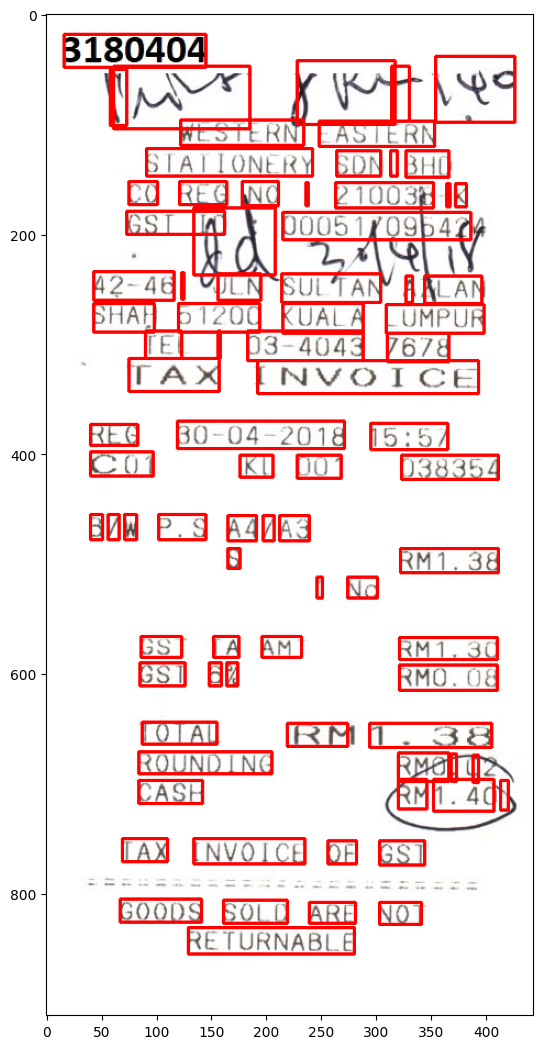

In [ ]:
img = random.choice(TRAIN_IMAGES)
visualize_image(img, get_annotated_file(img))

In [7]:
x, y = generate_region_affinity_heatmap(image_path=img)
image = normalize_image(np.asarray(Image.open(img)))

Image and region map


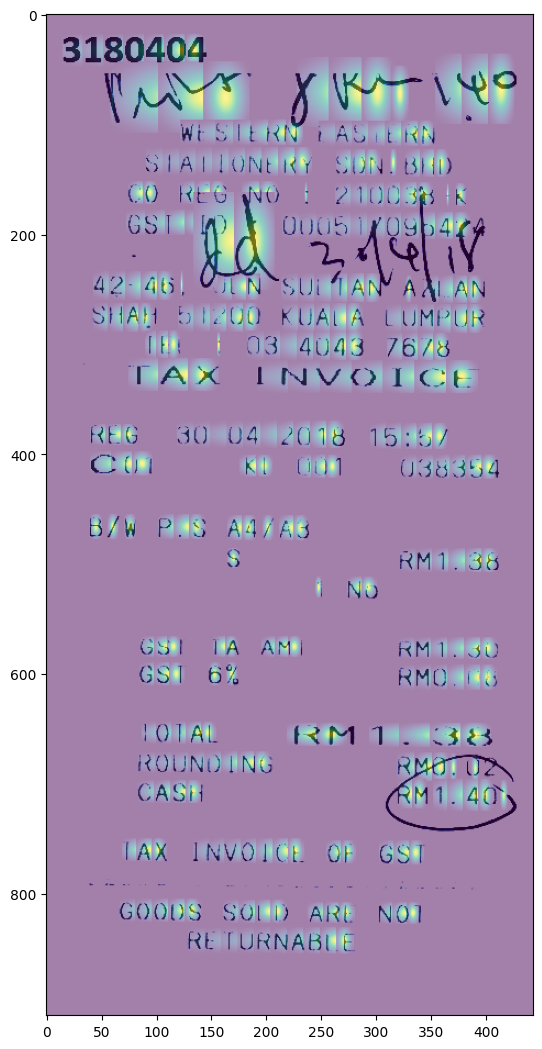

In [8]:
print("Image and region map")
visualize_ndarray_image(images=[image, x], opacity=[1, 0.5])

Image and affinity map


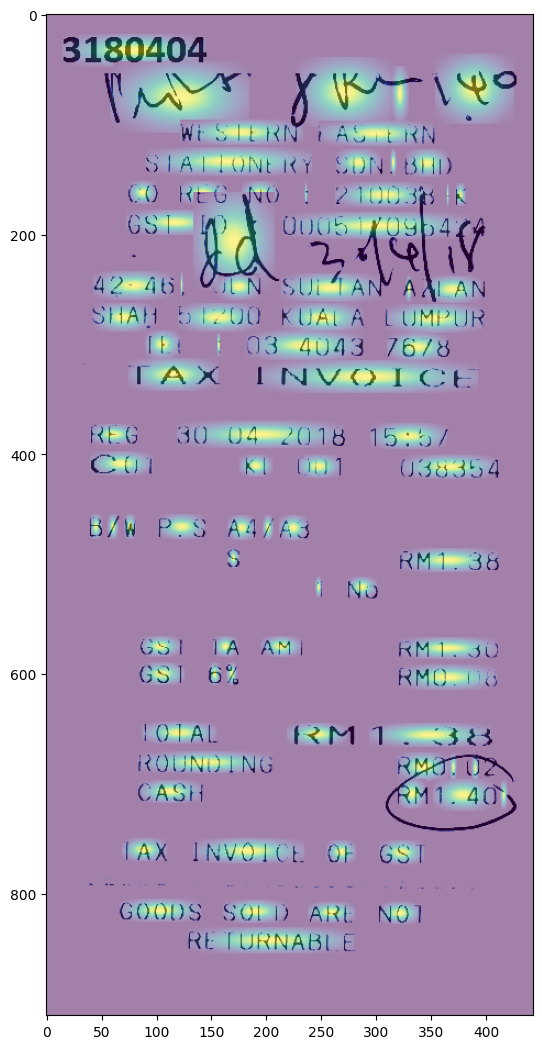

In [9]:
print("Image and affinity map")
visualize_ndarray_image(images=[image, y], opacity=[1, 0.5])

In [10]:
train_df = get_df(DATA_DIR_RAW_TRAIN)
test_df = get_df(DATA_DIR_RAW_TEST)

In [11]:
train_df.head()

,image,annotations
0,../data/raw/train/X51005442376.jpg,../data/raw/train/X51005442376_ocr.json
1,../data/raw/train/X51009453804.jpg,../data/raw/train/X51009453804_ocr.json
2,../data/raw/train/X51006401723.jpg,../data/raw/train/X51006401723_ocr.json
3,../data/raw/train/X51006913023.jpg,../data/raw/train/X51006913023_ocr.json
4,../data/raw/train/X51007846451.jpg,../data/raw/train/X51007846451_ocr.json


In [12]:
train_df, val_df = split_data(df=train_df, split_ratio=[0.8])
print(f"Length of train_df = {len(train_df)}")
print(f"Length of val_df = {len(val_df)}")
print(f"Length of test_df = {len(test_df)}")

Length of train_df = 500
Length of val_df = 126
Length of test_df = 361


In [13]:
# Get data loaders and visualize its output
data_generator = OCRData(train_data=train_df, val_data=val_df, test_data=test_df)

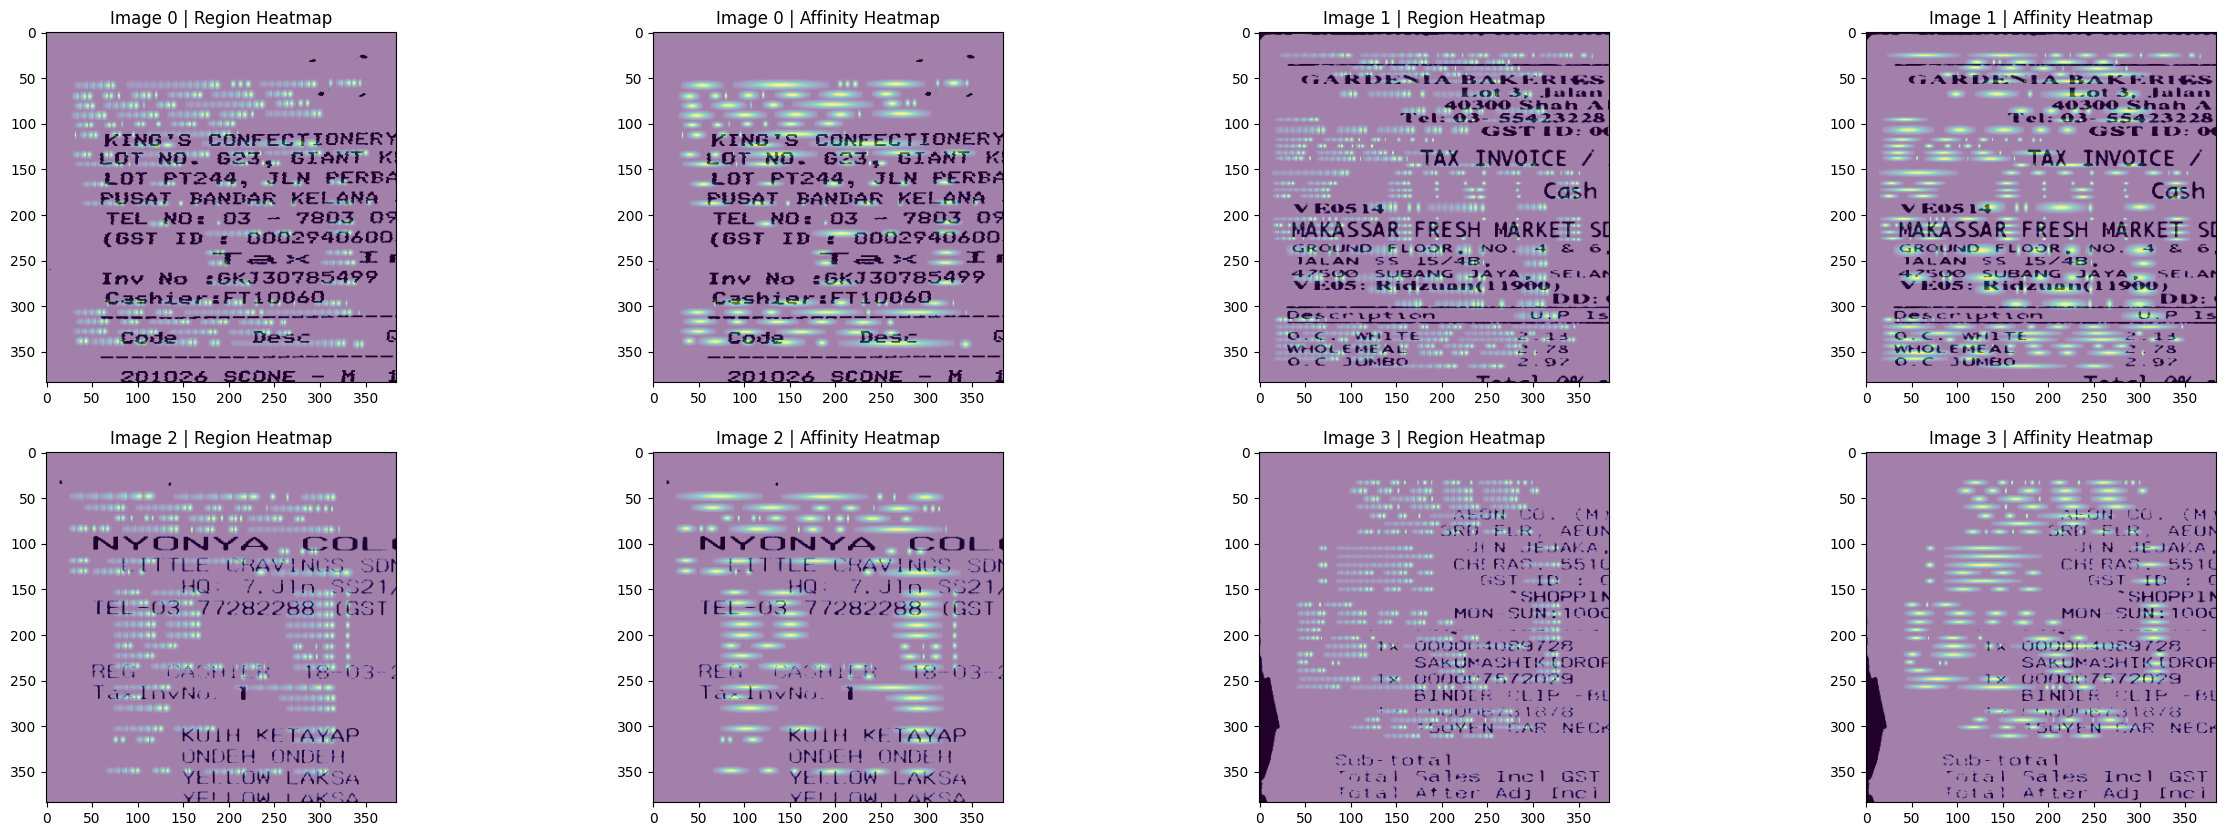

In [14]:
data_generator.visualize()

In [15]:
train_loader, val_loader, test_loader = data_generator.get_data_loaders()

In [16]:
model = LitOCRModel(
    criteria=JointMSELoss(),
    loaders={
        "train": train_loader,
        "validation": val_loader,
        "test": test_loader
    }
)

Model Summary:
 CRAFT(
  (basenet): VGG16_BN(
    (block_1): Sequential(
      (BLOCK_1_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BLOCK_1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (BLOCK_1_2): ReLU(inplace=True)
      (BLOCK_1_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BLOCK_1_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (BLOCK_1_5): ReLU(inplace=True)
      (BLOCK_1_6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (BLOCK_1_7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BLOCK_1_8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (BLOCK_1_9): ReLU(inplace=True)
      (BLOCK_1_10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BLOCK_1_11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tra

In [21]:
# LR Finder
# trainer = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None
trainer = pl.Trainer(auto_lr_find=True, accelerator="mps")
lr_finder = trainer.tuner.lr_find(model)
fig = lr_finder.plot(suggest=True)
fig.show()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/tyche/Nikhil/OCR/nbs/lightning_logs


Finding best initial lr:   0%|                  | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   1%|          | 1/100 [00:30<50:05, 30.36s/it]

Finding best initial lr:   2%|▏         | 2/100 [00:59<48:36, 29.76s/it]

Finding best initial lr:   3%|▎         | 3/100 [01:22<43:04, 26.64s/it]

Finding best initial lr:   4%|▍         | 4/100 [01:50<43:05, 26.93s/it]

Finding best initial lr:   5%|▌         | 5/100 [02:15<41:58, 26.51s/it]

Finding best initial lr:   6%|▌         | 6/100 [02:39<39:52, 25.45s/it]

Finding best initial lr:   7%|▋         | 7/100 [03:14<44:42, 28.84s/it]

Finding best initial lr:   8%|▊         | 8/100 [03:44<44:28, 29.01s/it]

Finding best initial lr:   9%|▉         | 9/100 [04:11<42:56, 28.31s/it]

Finding best initial lr:  10%|▉        | 

RuntimeError: MPS backend out of memory (MPS allocated: 54.68 GB, other allocations: 26.51 GB, max allowed: 81.60 GB). Tried to allocate 576.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [18]:
torch.backends.mps.is_available()

True